In [1]:
import numpy as np
import matplotlib.pyplot as plt
import HUXt as H
import astropy.units as u
%matplotlib inline

In [2]:
v_boundary = np.ones(128) * 400 * u.km/u.s
# Get a list of different CMEs to include in the model.
daysec = 86400
cme1 = H.ConeCME(t_launch=0.5*daysec, longitude=0, width=40, v=700, thickness=10)
cme_list = [cme1]

# Set up HUXt to run a simulation for 5 days, and output model data every 4 timesteps (about 35min)
cone_model = H.HUXt2DCME(simtime=0.5, dt_scale=4)
cone_model.solve_cone_cme(v_boundary, cme_list, save=False) 


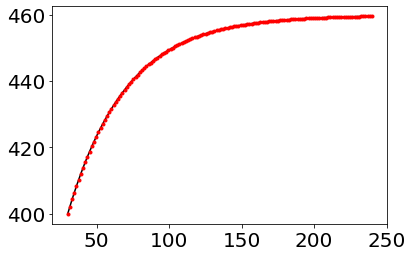

In [3]:
fig, ax = plt.subplots()
ax.plot(cone_model.r.value, cone_model.v_grid_amb[0,:,0], 'k-')
ax.plot(cone_model.r.value, cone_model.v_grid_amb[0,:,10], 'r.')

In [30]:
# Create a the inner boundary solar wind condition (this must be 128 in size)
v_boundary = np.ones(128) * 400 * u.km/u.s
# Add two fast streams
v_boundary[10:20] = v_boundary[10:20] * 2.0
v_boundary[60:80] = v_boundary[60:80] * 2.0

# Get a list of different CMEs to include in the model.
daysec = 86400
cme1 = H.ConeCME(t_launch=0.5*daysec, longitude=0, width=40, v=700, thickness=10)
cme_list = [cme1]

# Set up HUXt to run a simulation for 5 days, and output model data every 4 timesteps (about 35min)
cone_model = H.HUXt2DCME(simtime=27, dt_scale=30)
# Run the model, with a tag to go on output filename
tag = "accel_test"
cone_model.solve_cone_cme(v_boundary, cme_list, save=False, tag=tag) 
# Make an MP4 of the solution with CME
#tag = "cone_run"
#cone_model.animate('cme', tag)
# Make an MP4 of the solution of ambient wind
#tag = 'ambient'
#cone_model.animate('ambient', tag)



458.9591451117489 km / s


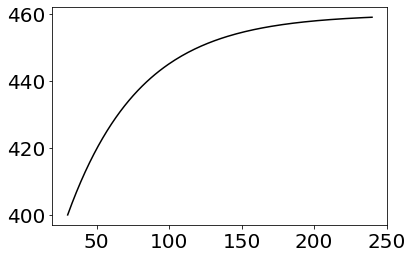

In [40]:
fig, ax = plt.subplots()
id_lon = np.argmin(np.abs(cone_model.lon.value - np.deg2rad(90)))
ax.plot(cone_model.r.value, cone_model.v_grid_amb[0,:,id_lon], 'k-')
print(np.max(cone_model.v_grid_amb[0,:,id_lon]))

(400, 1000)

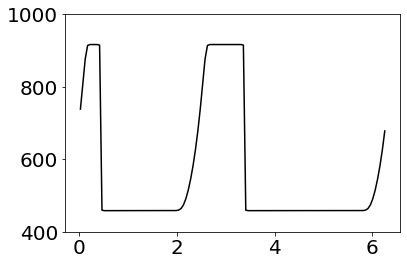

In [34]:
fig, ax = plt.subplots()
id_rad = np.argmin(np.abs(cone_model.r.value - 215))
ax.plot(cone_model.lon.value, cone_model.v_grid_amb[0,id_rad,:], 'k-')
ax.set_ylim(400,1000)

(400, 1000)

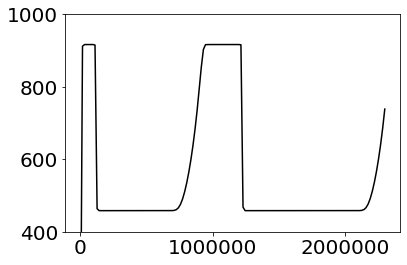

In [37]:
fig, ax = plt.subplots()
id_rad = np.argmin(np.abs(cone_model.r.value - 215))
id_lon = np.argmin(np.abs(cone_model.lon.value - np.deg2rad(0)))
ax.plot(cone_model.time_out, np.flipud(cone_model.v_grid_amb[:,id_rad, id_lon]), 'k-')
ax.set_ylim(400,1000)

(<Figure size 1008x1008 with 2 Axes>,
 <matplotlib.axes._subplots.PolarAxesSubplot at 0x268c627e710>)

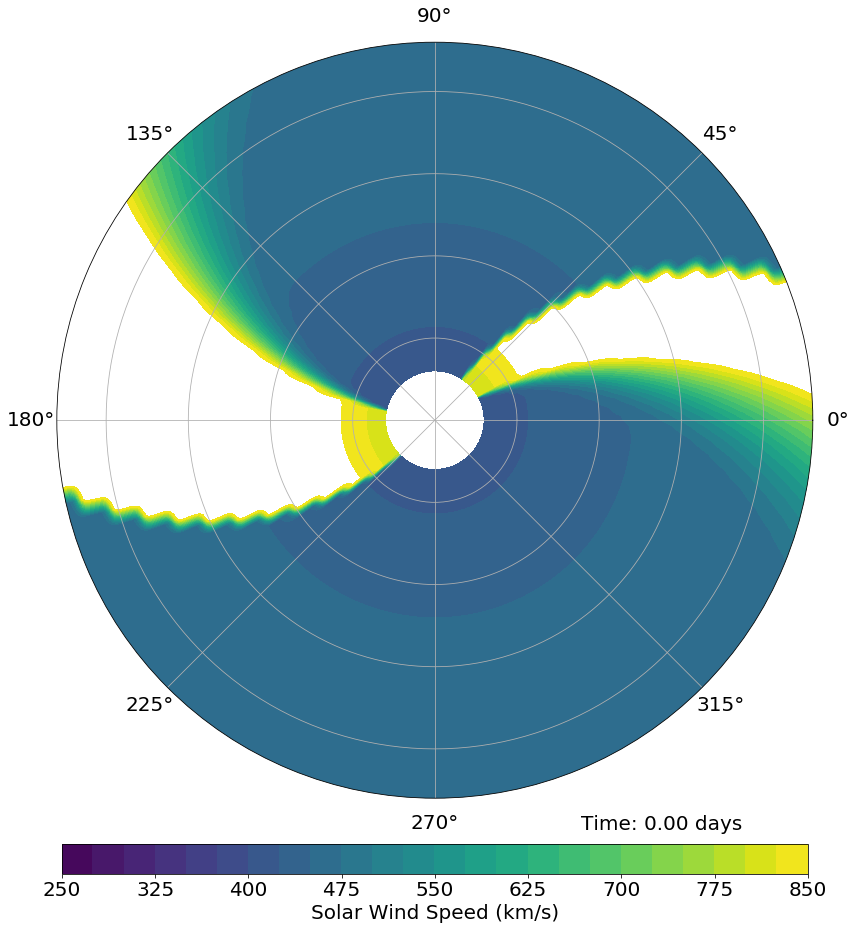

In [38]:
cone_model.plot(0, 'ambient')

In [29]:
(27*24*60*60 / 128) / cone_model.dt

<Quantity 34.67935687 1 / s>